In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import shap
import pickle
import cloudpickle
import numpy as np
import scipy as sp
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from diro2c_wrapper import generate_diro2c_explanation, plot_diro2c_2d, plot_diro2c_tree
shap.initjs()
%matplotlib inline

# Setup Task

In [3]:
X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, class_sep=0.75, random_state=2)
X *= 100
feature_names = np.array(['x1', 'x2'])

In [4]:
pd.DataFrame(X, columns=feature_names).describe()

,x1,x2
count,300.000000,300.000000
mean,-2.920353,-3.233006
std,92.872732,101.251122
min,-188.394649,-251.957930
25%,-79.144230,-74.866120
50%,-15.527081,-6.890370
75%,69.936232,60.078319
max,332.353481,316.096597


In [5]:
tree = DecisionTreeClassifier(max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=1)

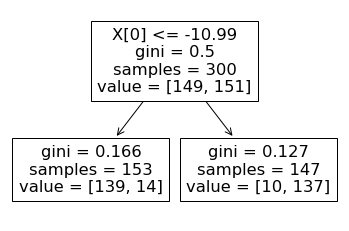

In [6]:
from sklearn.tree import plot_tree
plot_tree(tree);

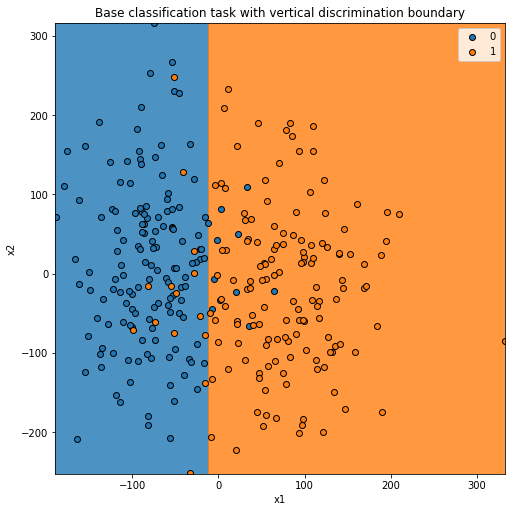

In [7]:
fig, ax = plt.subplots(figsize=(7, 7), constrained_layout=True)
plot_decision_boundary(X, y, 'Base classification task with vertical discrimination boundary', feature_names,
                       predict=tree.predict, class_names=tree.classes_,
                       fig=fig, ax=ax)

In [8]:
clf_a = tree

In [9]:
from helper_models import ModifiedClassifier
class MyModifiedClassifier(ModifiedClassifier):
    def _preprocess(self, X):
        X2 = X.copy()
        X2[(-100 <= X[:, 1]) & (X[:, 1] < 0), 0] += 50
        return X2
    
clf_b = MyModifiedClassifier(tree)
clf_b.fit(X, y)

MyModifiedClassifier(base_model=DecisionTreeClassifier(max_depth=1))

In [10]:
comparer = ModelComparer(clf_a, clf_b, feature_names)
comparer.fit(X, y)

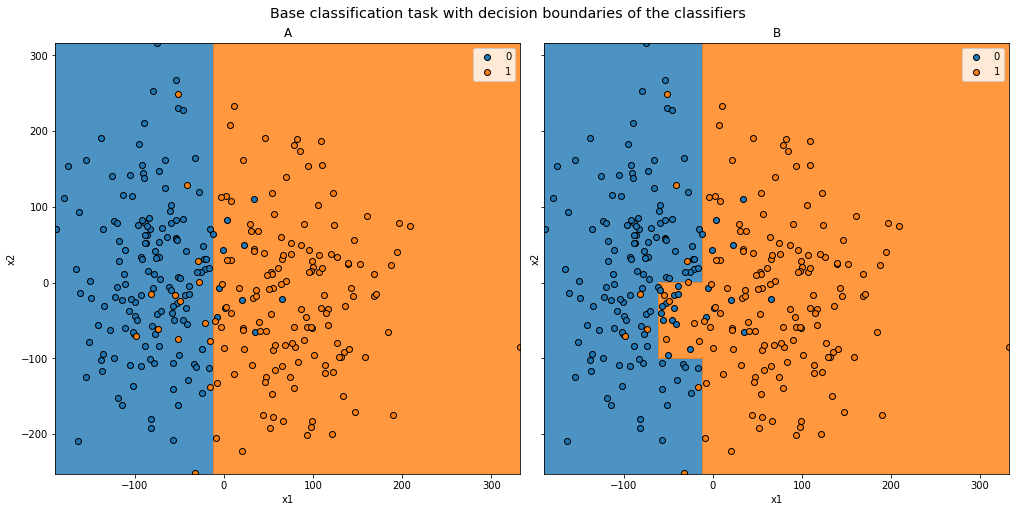

In [11]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

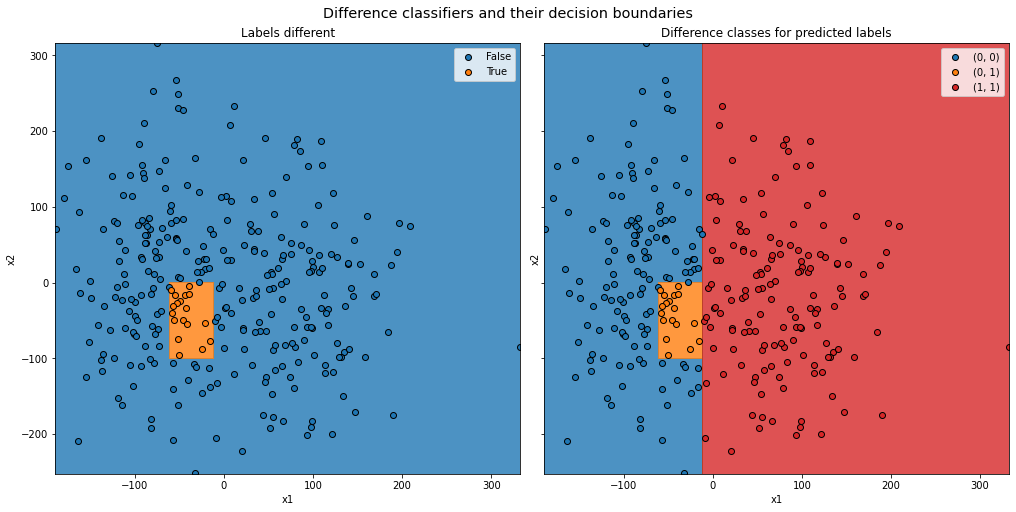

In [12]:
comparer.plot_decision_boundaries(X)

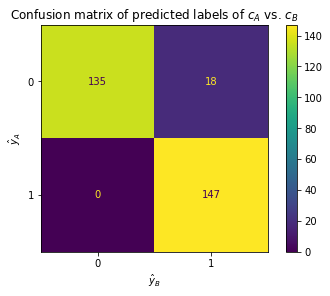

In [13]:
comparer.plot_confusion_matrix(X)

# Explain using Interpretability Methods

In [14]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])

CPU times: user 5.19 s, sys: 86.1 ms, total: 5.28 s
Wall time: 5.48 s


In [15]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((300, 2), (0,), (0,))

In [16]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)
mclass_diff = comparer.predict_mclass_diff(explanations.data)

# Global Explanations

## SHAP-based Individual Classifiers' Explanations

A solely bases its decisions on x1, whereas B also takes x2 to a lesser extent into account.

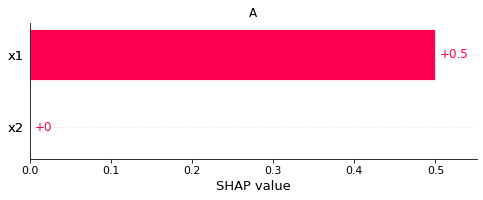

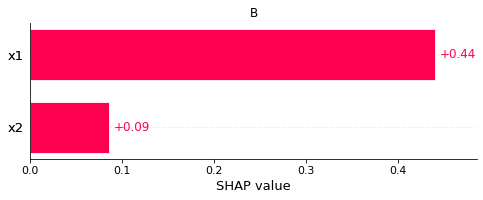

In [17]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.A[:, :, 1])
plot_feature_importance_bar(feature_importance, 'A', feature_order)
feature_order, feature_importance = calc_feature_order(explanations.indiv.labels.B[:, :, 1])
plot_feature_importance_bar(feature_importance, 'B', feature_order)

In [20]:
feature_order, _ = calc_feature_order(explanations.indiv.labels[:, :, 1])

In [21]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.indiv.labels[:, [feature_idx], 1])
    plot_feature_effects(explanations.indiv.labels[:, [feature_idx], 1], color=is_pred_diff)
it = iter(feature_order)

The effects of x1 in A are simple: low values decrease the outcome, high values increase it. It's similar in B, but with a step in between close to 0, where for the group of instances classified differently (colored red in the dependence plots) the effect is slightly positive, but for the group of instances classified equally the effect is negative. These difference are only possible because of interacting effects with another feature.

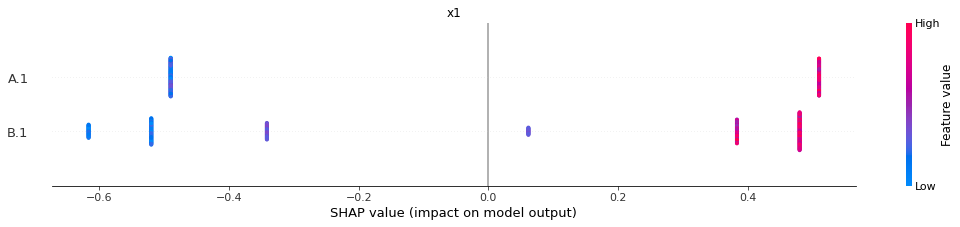

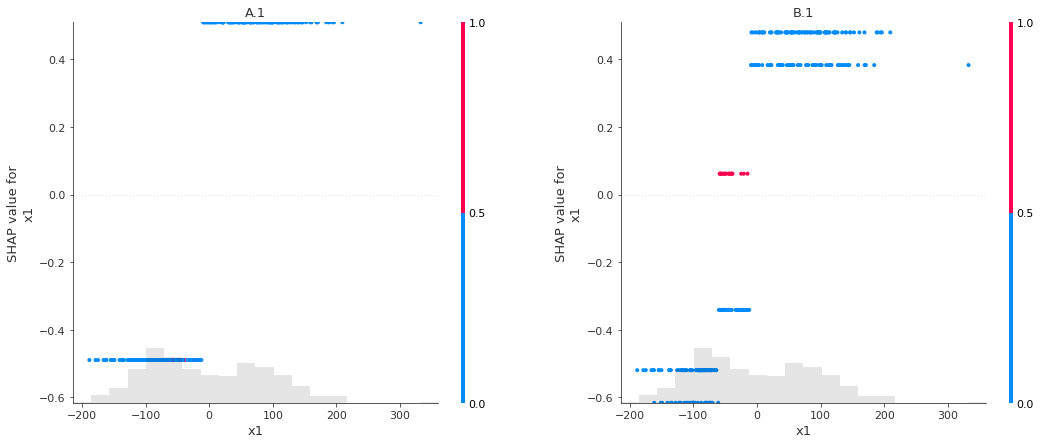

In [22]:
plot_next_feature()

The effect of x2 in A is constant, the effect in B is constant as well with an exception between approx. -100 to 0, where for one group there is a slight increase in outcome, but which are not classified differently. And there is another group with higher increase, that is classified differently.

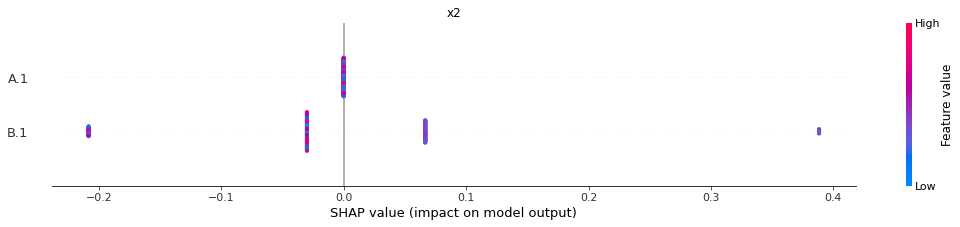

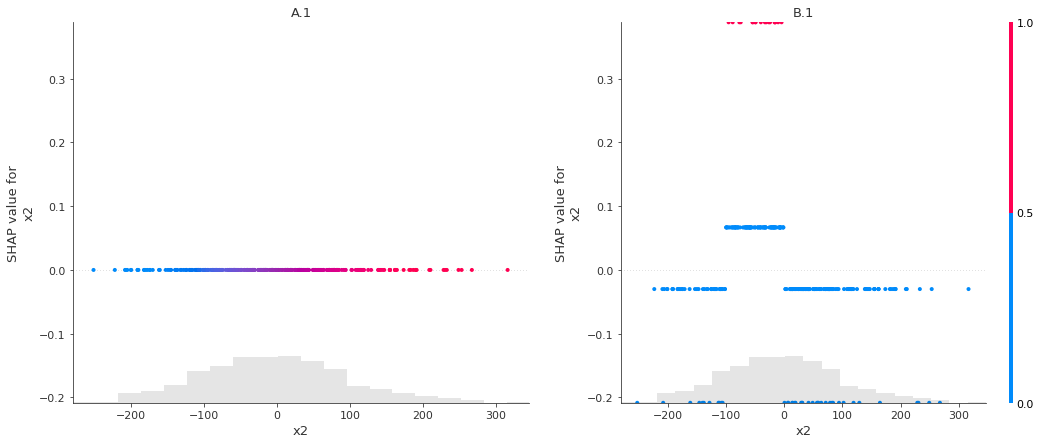

In [23]:
plot_next_feature()

## SHAP-based Difference Classifier Explanations

Only difference class $(0,1)$ is present in the importances plots. Interestingly, the importance of x2 is just made up of $(0,0)$ and $(0,1)$ SHAP values.

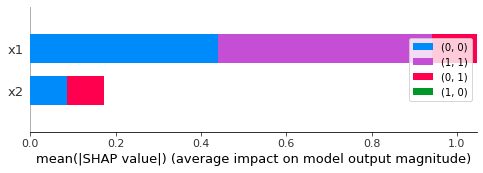

In [26]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
plot_feature_importance_bar(explanations.mclass_diff.labels)

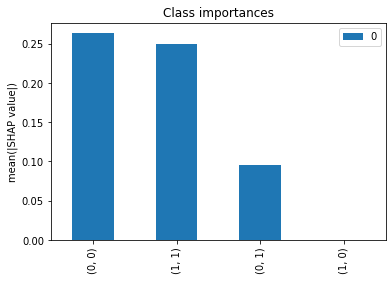

In [27]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [28]:
class_order = np.sort(class_order[:-1])

In [29]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order])
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx]][:, :, class_order], color=is_pred_diff)
it = iter(feature_order)

We can see that for low values of x1 the effect shifts towards $(0,0)$, while for high values it shifts towards $(1,1)$. In between, there are effects towards $(0,1)$ and $(0,0)$.

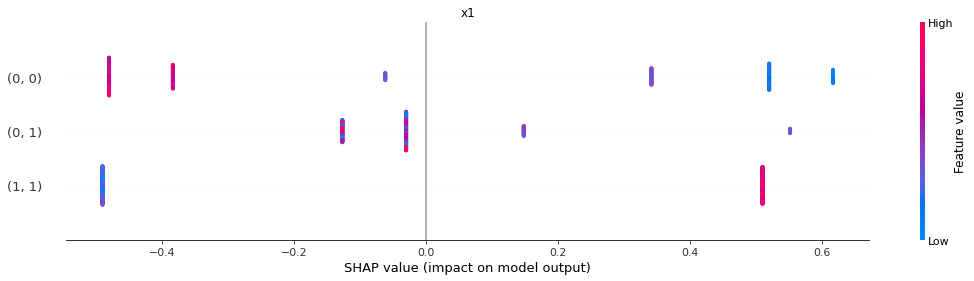

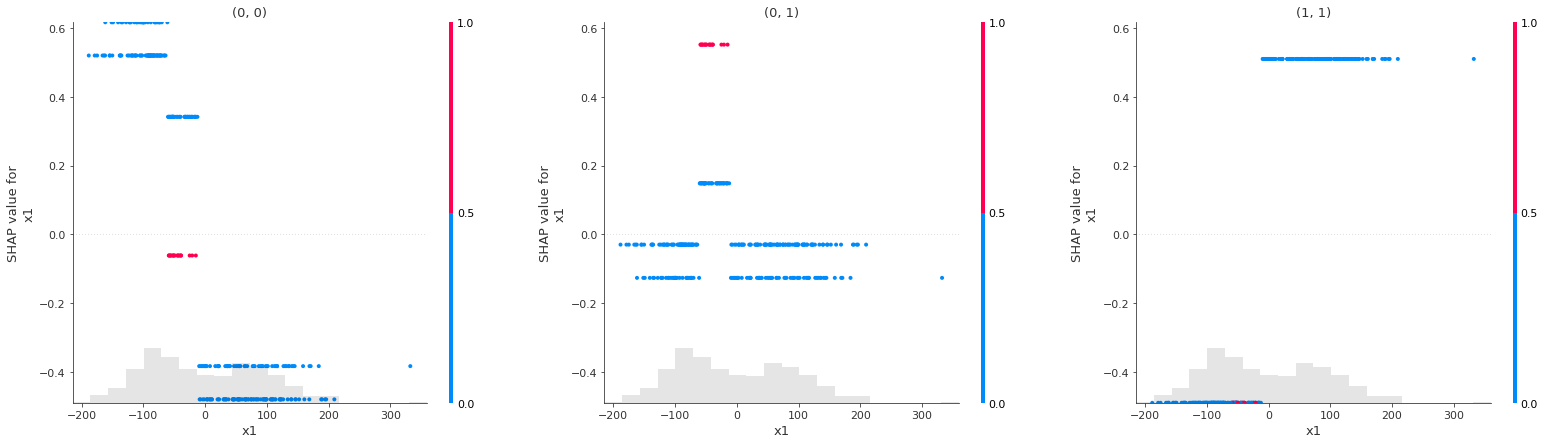

In [30]:
plot_next_feature()

Most effects of x2 are constant, except for the range between -100 and 0 where there are increased effects towards $(0,1)$.

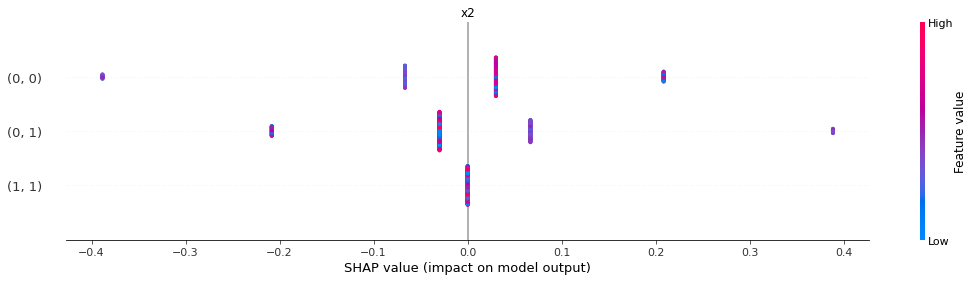

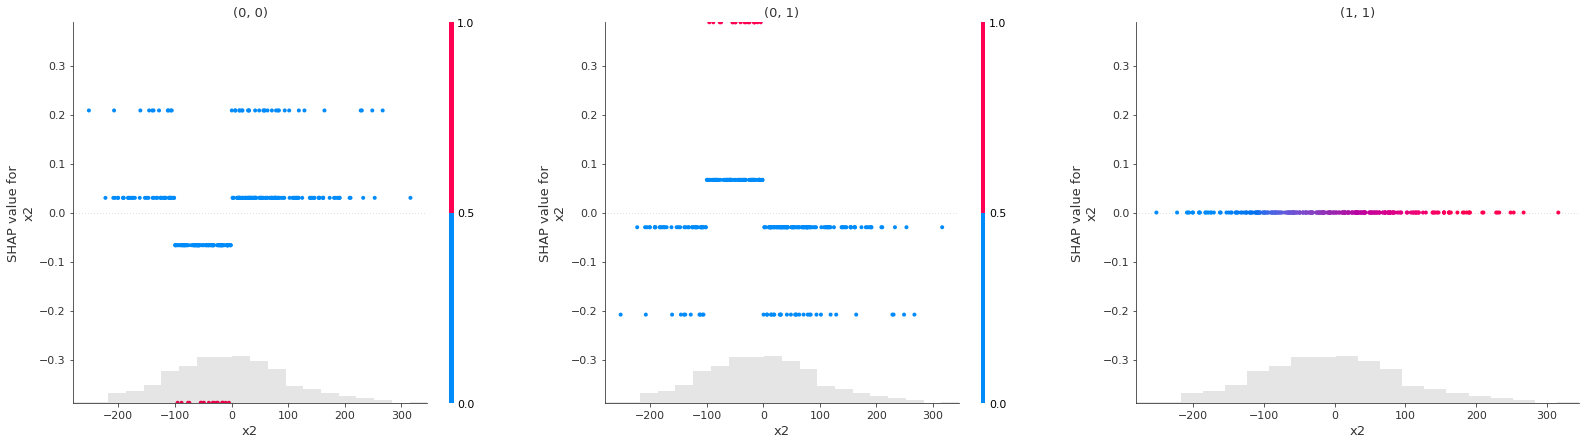

In [31]:
plot_next_feature()

# Local Explanations

In the dendrogram we can see, that at maximum three clusters are possible.

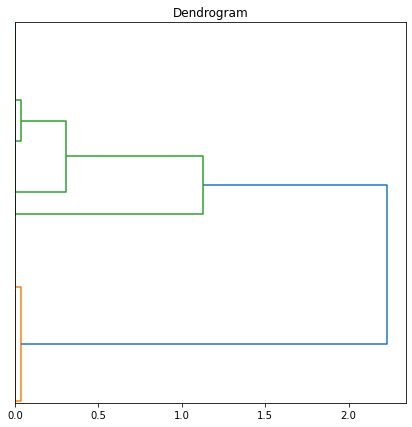

In [32]:
linkage_matrix = perform_hierarchical_clustering(explanations.mclass_diff.labels)
plot_dendrogram(linkage_matrix)

$n=2$ yields a clustering, where c2 contains instances classified $(0,0)$ and $(0,1)$.

In [37]:
clustering, cluster_names = extract_clustering(linkage_matrix, n_clusters=2)
explanations_clustered = explanations.cohorts(cluster_names[clustering])
occurences, clusters_of_interest = get_class_occurences_in_clusters(explanations_clustered, cluster_names, comparer)
occurences

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c1,0,0,0,147
c2,135,18,0,0


In [38]:
def get_next_cluster():
    cluster = next(cluster_it)
    shap_values = explanations_clustered.mclass_diff.labels.cohorts[cluster]
    pred_classes = comparer.predict_mclass_diff(shap_values.data)
    pred_class_names = comparer.class_names[pred_classes]
    diff_classes = comparer.difference_class_names[occurences.loc[cluster, comparer.difference_class_names] > 0]
    classes = np.unique(pred_class_names)
    display(occurences.loc[[cluster], :])
    return cluster, shap_values, pred_class_names, diff_classes, classes
cluster_it = iter(clusters_of_interest)

## 1. Cluster

These feature value distributions are different locally compared to the global level:
- x1 reaches only up to -12

Using the knowledge about feature value distributions and global explanations, I can interpret that:
- if x1 was higher, the effect would shift towards $(1,1)$: Setting it to 0 changes all predictions to this class.

Using the local explanations I can interpret that:
- if x1 was lower, the effect would shift towards $(0,0)$: setting it to -80 changes the predictions of all instances classified differently to this class and does not change the predictions of instances classified equally
- if x2 was lower or higher, the effect would shift towards $(0,0)$: setting it to -150 or 50 changes the predictions of all instances classified differently to this class and does not change the predictions of instances classified equally

In [39]:
cluster, shap_values, pred_classes, diff_classes, classes = get_next_cluster()

,"(0, 0)","(0, 1)","(1, 0)","(1, 1)"
c2,135,18,0,0


In [40]:
df = pd.DataFrame(shap_values.data, columns=shap_values.feature_names)
df.describe()

,x1,x2
count,153.000000,153.000000
mean,-80.378460,9.179534
std,40.126769,104.063423
min,-188.394649,-251.957930
25%,-104.786752,-61.275156
50%,-78.292480,4.195763
75%,-51.736118,71.780570
max,-12.420569,316.096597


In [41]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = 0
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",135.0,NaN
"(1, 1)",NaN,135.0


,before,after
"(0, 1)",18.0,NaN
"(1, 1)",NaN,18.0


### SHAP-based Difference Classifier Explanations

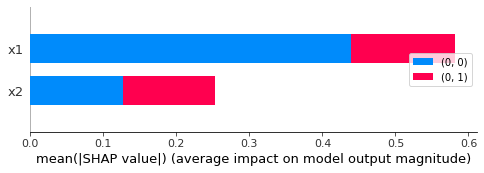

In [42]:
feature_order, feature_importances = calc_feature_order(shap_values[:, :, classes])
plot_feature_importance_bar(shap_values[:, :, classes])

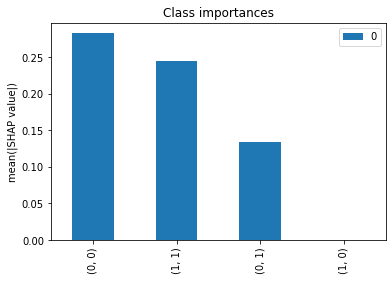

In [43]:
class_order, class_importances = calc_class_order(shap_values)
plot_class_importances(class_importances, class_order, shap_values.output_names)

In [44]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_importance_scatter(shap_values[:, [feature_idx]])
    for diff_class in diff_classes:
        plot_feature_effects(shap_values[:, [feature_idx]], highlight=pred_classes == diff_class, title=f'Highighted: {diff_class}')
it = iter(feature_order)

The instances classified differently are in the upper part. If there x1 value would be decreased, the effect would shift towards $(0,0)$.

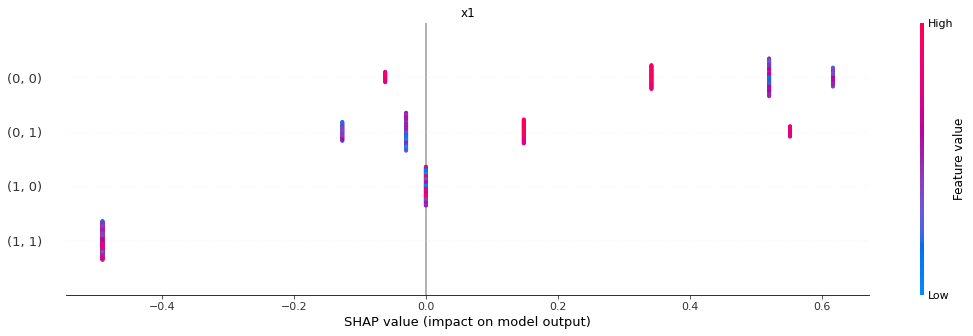

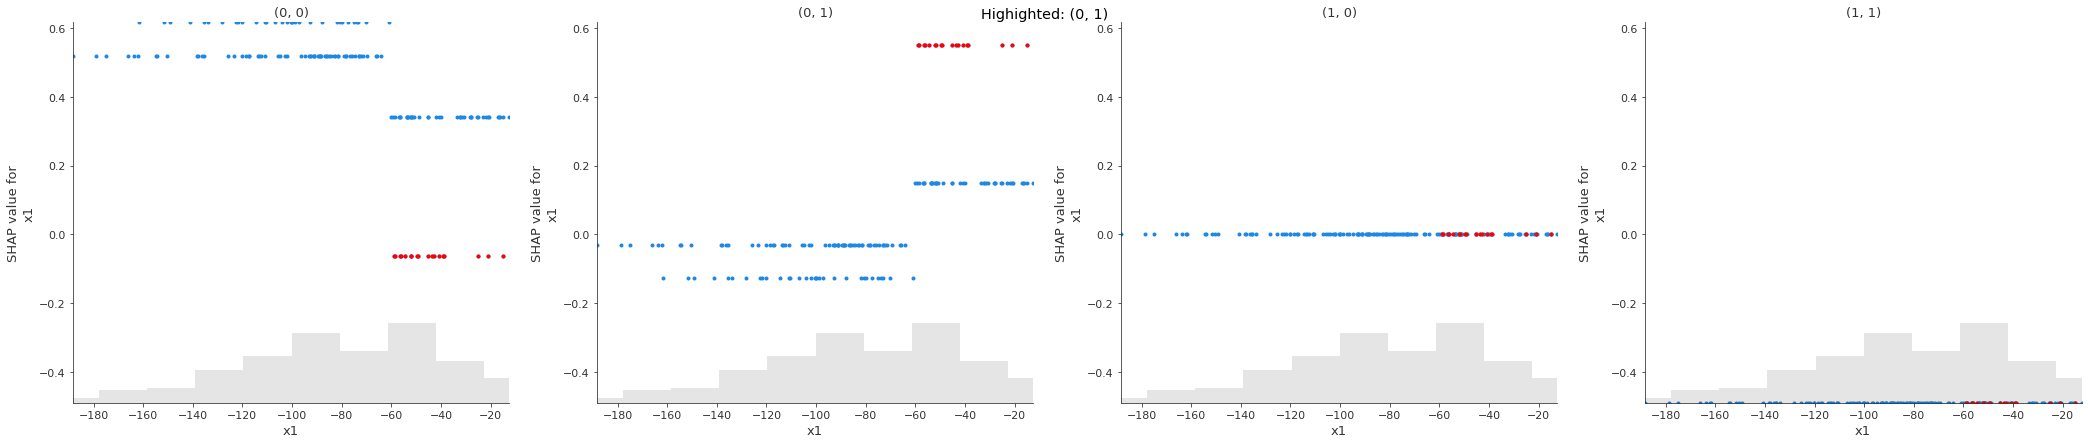

In [45]:
plot_next_feature()

In [47]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x1'] = -80
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",135,135


,before,after
"(0, 0)",NaN,18.0
"(0, 1)",18.0,NaN


Instances classified differently are in a narrow range between -100 and 0, if they are decreased or increased, the effect would shift towards $(0,0)$.

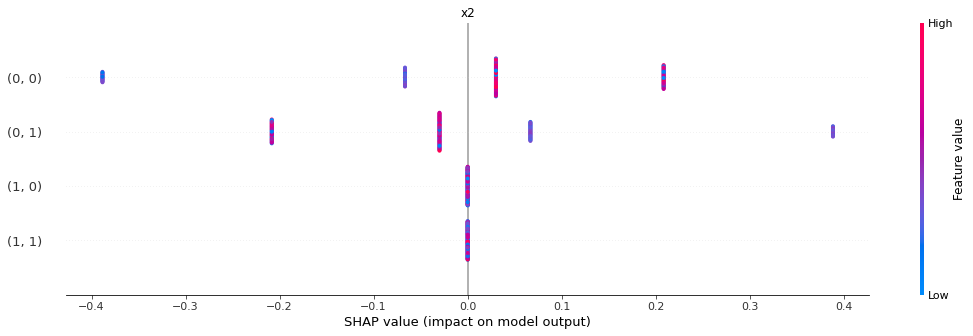

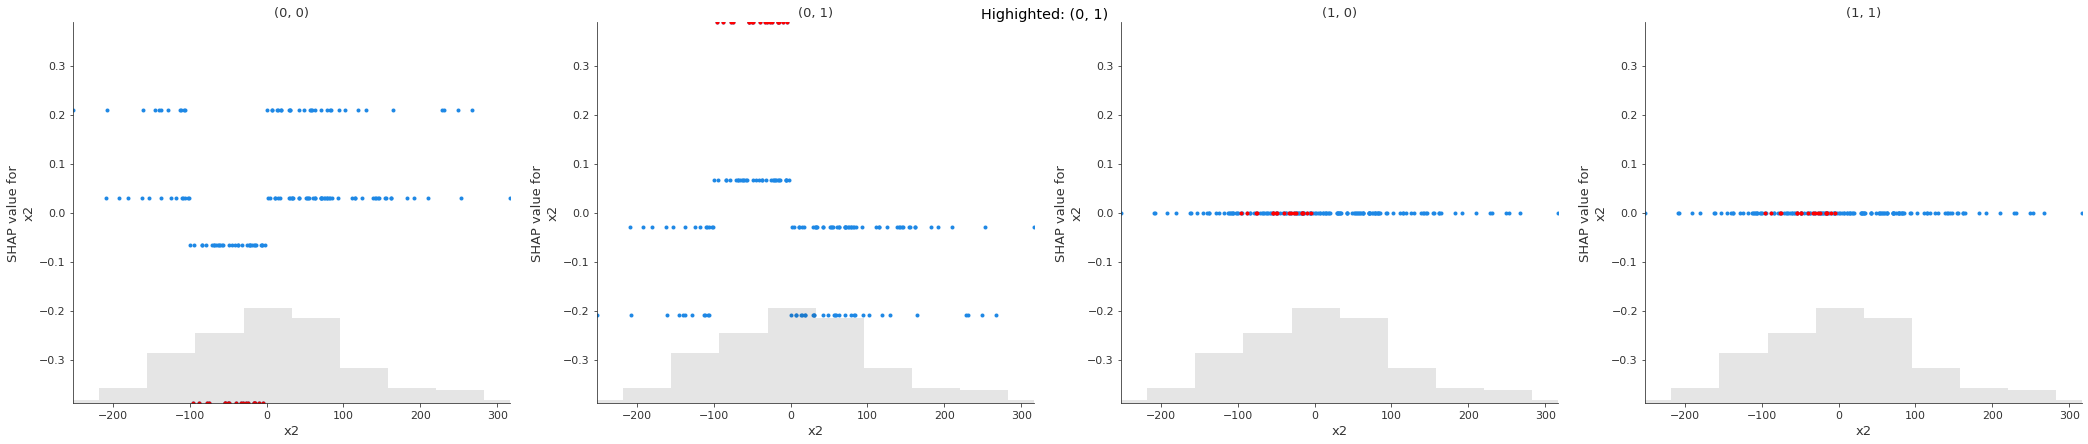

In [46]:
plot_next_feature()

In [48]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = -150
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",135,135


,before,after
"(0, 0)",NaN,18.0
"(0, 1)",18.0,NaN


In [49]:
X = pd.DataFrame(shap_values.data.copy(), columns=shap_values.feature_names)
y_before = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
X['x2'] = 50
y_after = pd.Series(comparer.class_names[comparer.predict_mclass_diff(X)])
for class_ in classes:
    mask = pred_classes == class_
    display(pd.DataFrame({'before': y_before[mask].value_counts(),
                          'after': y_after[mask].value_counts()}))

,before,after
"(0, 0)",135,135


,before,after
"(0, 0)",NaN,18.0
"(0, 1)",18.0,NaN


### diro2c

diro2c came to the same conclusion, marking the exact decision boundaries of this class.

In [50]:
diff_class = diff_classes[0]
start_idx = np.where(pred_classes == diff_class)[0][0]

In [51]:
%%time
explanation = generate_diro2c_explanation(shap_values.data, start_idx, comparer, diff_class)

CPU times: user 17.8 s, sys: 130 ms, total: 18 s
Wall time: 18.8 s


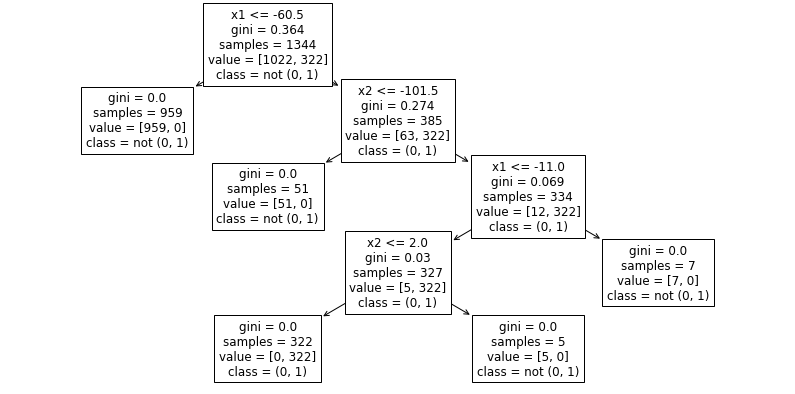

In [52]:
fig, ax = plt.subplots(figsize=(14, 7))
plot_diro2c_tree(explanation)

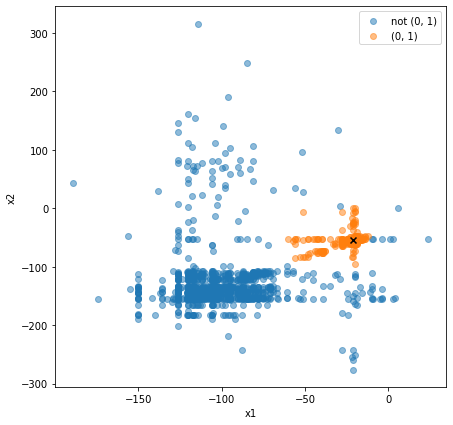

In [53]:
x = shap_values.data[start_idx, :]
plot_diro2c_2d(explanation, 'x1', 'x2', highlight=x)